# Automatic Differentiation for Scalars (Differentiable Programming)

## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements)
  * [Knowledge](#Knowledge)
  * [Python Modules](#Python-Modules)
  * [Gradient Calculation by Backpropagation](#Gradient-Calculation-by-Backpropagation)
  * [Chain Rule](#Chain-Rule)
  * [Backpropagation](#Backpropagation)
* [Exercises](#Exercises)
  * [Compute the derivatives (pen & paper)](#Compute-the-derivatives-(pen-%26amp%3B-paper))
  * [Autodiff class Scalar](#Autodiff-class-%3Ccode%3EScalar%3C%2Fcode%3E)
* [Example: A computational graph using autodiff](#Example%3A-A-computational-graph-using-autodiff)
* [Example: Linear Regression using autodiff](#Example%3A-Linear-Regression-using-autodiff)
* [Literature](#Literature)
* [Licenses](#Licenses)

## Introduction

In this notebook you will implement a Scalar class that supports automatic differentiation.
Mostly, machine learning models correspond to mathematical functions that are composed by simple mathematical operators, e.g., $+$, $*$ and $.^2$. So, the function can be represented by a computational graph.

For example the function $f(x,y,z) = x + y * z$ can be represented by the following computional graph:

        y    z
         \  / 
      x    *  
        \ /
         +
         |
         f


The value of $f$ can be computed for given values of $x$, $y$ and $z$.
_Automatic differentiation_ is a procedure to compute the values of the derivatives of the output with repect to the inputs efficiently, i.e. here $\frac{\partial f}{\partial x}$,
$\frac{\partial f}{\partial y}$ and $\frac{\partial f}{\partial z}$ .



In the context of machine learning, we typically have:

- $f$ is the cost function (including the machine learning model). So, we restrict ourself in the following to a scalar output of the computational graph.
- We want to compute the partial derivatives of the cost with respect to the parameters of the machine learning model.

Recap: In the introduction of machine learning you have learnt that "learning" is often minimizazion of the cost function on the training data set. We used _gradient descent_ as optimization procedure.


## Requirements

### Knowledge
This notebook deals with computational graphs, the chain rule and backpropagation. A recommended read on the topic is
* [Calculus on Computational Graphs: Backpropagation](http://colah.github.io/posts/2015-08-Backprop/) by C. Olah [[OLA15]](#OLA15).

The Python implementation of the autodiff class is inspired by MXNet and discussed in-depth in the article
* [Deep Learning Programming Style](https://mxnet.apache.org/api/architecture/program_model) by Apache MXNet [[AP17]](#AP17).

### Python Modules

In [4]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

### Gradient Calculation by Backpropagation

Backpropagation (reverse mode automatic differentiation) is a method for efficient calculation of the gradient (and higher order derivatives).

If the (partial) derivative is defined for each operator, gradients of the computation graph can be computated automatically by backpropagation. The mathematical basis is the chain rule of calculus.


#### Gradient

The gradient ($grad$) of the (scalar) function $f(.)$ with respect to (w.r.t.) $\theta$ is the vector of the partial derivatives:

$$
grad_\theta f(\theta)= 
\vec \nabla_\theta f(\theta) = 
\left(
\begin{array}{c}
\frac{\partial }{\partial \theta_1}\\
\frac{\partial }{\partial \theta_2}\\
\dots \\
\frac{\partial }{\partial \theta_n}\\
\end{array}
\right)f(\theta) = 
\left(
\begin{array}{c}
\frac{\partial f(\theta)}{\partial \theta_1}\\
\frac{\partial f(\theta)}{\partial \theta_2}\\
\dots \\
\frac{\partial f(\theta)}{\partial \theta_n}\\
\end{array}
\right)
$$

<!--
E.g., with $\theta = \left\{x,y,z\right\}$, 


$$
grad_\theta f(\theta)= 
\vec \nabla_\theta f(\theta) = 
\left(
\begin{array}{c}
\frac{\partial }{\partial x}\\
\frac{\partial }{\partial y}\\
\frac{\partial }{\partial z}\\
\end{array}
\right)f(\theta) = 
\left(
\begin{array}{c}
\frac{\partial f(x,y,z)}{\partial x}\\
\frac{\partial f(x,y,z)}{\partial y}\\
\frac{\partial f(x,y,z)}{\partial z}\\
\end{array}
\right)
$$
-->

The principle idea of "reverse automatic differentiation" is to implement for each operator additionally how their derivative is computed. By the chain rule of calculus the individual derivatives of the operators are combined to computed the values of the wanted gradient, here $\frac{\partial f}{\partial \theta_0}$,
$\frac{\partial f}{\partial \theta_1}$, $\frac{\partial f}{\partial \theta_2}$ etc.

At the end of this notebook, we'll apply our autodiff class in a linear regression example and compute the gradients of the weight and bias using autodiff. 


### Math Recap: Chain Rule
<!-- with $z = z(x(t), y(t))$

$$
 \frac{ d z}{d t} =  \frac{\partial z}{\partial x} \frac{d x}{d t} + \frac{\partial z}{\partial y} \frac{d y}{d t}
$$ -->


Chain rule for a function $c(b(w))$ ($c$ is a function of $b$ and $b$ is a function of $w$):

$$
\frac{\partial c(b(w))}{\partial w} = \frac{\partial c(b(w))}{\partial b} \frac{\partial b(w)}{\partial w} 
$$

#### Multivariable Chain Rule

$$
\frac{\partial}{\partial t} f(x(t), y(t)) =  \frac{\partial f}{\partial x} \frac{\partial x}{\partial t}+ \frac{\partial f}{\partial y}\frac{\partial y}{\partial t}
$$

If there are multiple paths to a parameter (here $t$), we must add the partial derivatives ("the gradients").  

#### Side Note: Total derivative vs partial derivative
For $z = z(a, b)$
$$
 \frac{ d z}{d a} =  \frac{\partial z}{\partial a} \frac{d a}{d a} + \frac{\partial z}{\partial b} \frac{d b}{d a} = \frac{\partial z}{\partial a} + \frac{\partial z}{\partial b} \frac{d b}{d a} 
$$

if $b$ is independent of $a$, i.e. $\frac{d b}{d a} = 0$, we have:

$$
 \frac{ d z}{d a} =
  \frac{\partial z}{\partial a} + \frac{\partial z}{\partial b} \frac{d b}{d a} =  \frac{\partial z}{\partial a} 
$$

#### Sum and product rule

if $b$ is not a function of $u$:

$$
 \frac{ \partial (a b)}{\partial u} =  \frac{\partial a}{\partial u} b + a \frac{\partial b}{\partial u} = \frac{\partial a}{\partial u} b
$$

$$
 \frac{ \partial (a(u) + b)}{\partial u} =  \frac{\partial a}{\partial u}
$$


### Backpropagation

We have a computational graph to compute $c$ and two parameters in the graph $v$ and $w$. `o1,o2` and `o3` are arbitrary operators.

This is represented by the following computational graph:

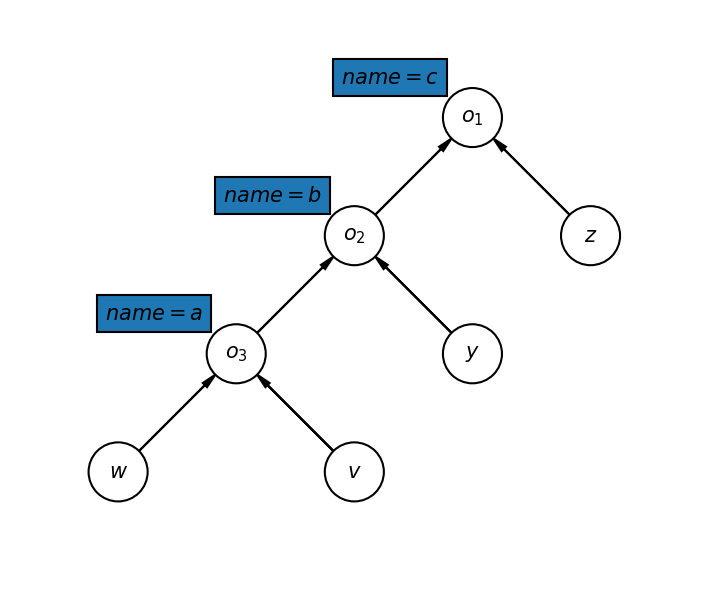

We want to compute the two partial derivatives $\frac{\partial c(b(a(w, v),y),z)}{\partial w}$ and $\frac{\partial c(b(a(w, v),y),z)}{\partial v}$.

Note that the application of the chain rule results in:
$$
\frac{\partial c(b(a(w, v),y),z)}{\partial w}  =
\frac{\partial c(b,z)}{\partial b}\frac{\partial b(a,y)}{\partial a} \frac{\partial a(w,v)}{\partial w}
$$


$$
\frac{\partial c(b(a(w, v),y),z)}{\partial v}  =
\frac{\partial c(b,z)}{\partial b}\frac{\partial b(a,y)}{\partial a} \frac{\partial a(w,v)}{\partial v}
$$

The first two factors of both expressions are the same. So, we need to compute them only once. That's the key idea of backpropagation. We need to compute such factors only once and can backpropagate them through the graph. This is much more efficient as to compute the partial derivatives independently.

#### Example for the given operator graph
Assume `o1` and `o3` are the multiplication operator ($*$) and `o2` is an add-operator ($+$).

Note that the application of the chain rule results in:

$$
\frac{\partial c}{\partial w}  =
\frac{\partial c(b,z)}{\partial b}\frac{\partial b}{\partial w} = 
\frac{\partial (z * b)}{\partial b}\frac{\partial b}{\partial w} 
= z \frac{\partial b}{\partial w}
$$


$$
\frac{\partial b}{\partial w} = \frac{\partial b(a,y)}{\partial w} = 
\frac{\partial b(a,y)}{\partial a} \frac{\partial a}{\partial w}=
\frac{\partial (a+y)}{\partial a}  \frac{\partial a}{\partial w}
= 1 \frac{\partial a}{\partial w}
$$


$$
\frac{\partial a}{\partial w} = \frac{\partial a(wv)}{\partial w} =  \frac{\partial a(wv)}{\partial w} = v
$$

so we have:

$$
\frac{\partial c}{\partial w}  = z * 1 * v = z * v
$$

For $\frac{\partial c}{\partial v}$ the first to factors of the chain rule ($\frac{\partial c}{\partial b} = z$ and $\frac{\partial b}{\partial a} = 1$) are the same and we can reuse them:

$$
\frac{\partial c}{\partial v}  = z * 1 * \frac{\partial a(w,v)}{\partial w} = z * 1 * w = z * w
$$

## Exercises
### Compute the derivatives (pen & paper)
Consider the function
$$
E = (w_1 \cdot x_1 + w_2 \cdot x_2) \cdot (w_3 \cdot x_3) = h \cdot g
$$

with

$$
h = (w_1 \cdot x_1 + w_2 \cdot x_2) 
$$

$$
g = (w_3 \cdot x_3)
$$

Compute the partial derivative of $E$ with respect to each of the weights:

- $\frac{\partial E}{\partial w_1}$ 

- $\frac{\partial E}{\partial w_2}$

- $\frac{\partial E}{\partial w_3}$

Note:

In general for a Product-Node $g \cdot h$: The factor $g$ flows back in the graph into the $h$-Branch for computing all derivatives $\frac{\partial E}{\partial w_i}$ in the $h$-Branch. So, we need first to compute $g$ in a forward pass to get the $g$ value. Then in the backward pass, we can propagate the $g$ values back through the $h$ branch to compute all derivatives on the $h$ branch $\frac{\partial E}{\partial w_i}$.

So, in general we must first compute a forward pass to get all values of all nodes. We often need the values to compute the derivatives at a node.

In [6]:
def round_and_hash(value, precision=4, dtype=np.float32):
    """ 
    Function to round and hash a scalar or numpy array of scalars.
    Used to compare results with true solutions without spoiling the solution.
    """
    rounded = np.array([value], dtype=dtype).round(decimals=precision)
    hashed = hashlib.md5(rounded).hexdigest()
    return hashed

#### Exercise: Pen and Paper Backpropagation
Given the function $ f(a,b,c) $ as a computational graph with the following values for the parameters:

$$
a = 2 \\
b = e \; (Euler \;number, \;b \approx 2.7183) \\
c = 3
$$



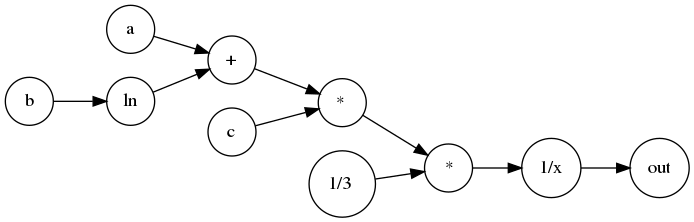

**Tasks:**
- Give an equation (inline) that expresses the graph.
- Calculate the partial derivatives $ \frac {\partial out} {\partial a}$, $ \frac {\partial out} {\partial b}$. and $ \frac {\partial out} {\partial c}$ using calculus on pen & paper by using the backprop procedure.
- For $b$ use the the true $Euler \;number$ and not the approximation
- Assign your results to variables `partial_a`,`partial_b` and `partial_c` to verify your solution with the software test below

Note: The node $1/x$ computes the inverse of the input $x$, i.e. the output is $1/x$ or $x^{-1}$

In [8]:
partial_a = None ### assign what you have calculated
partial_b = None ### assign what you have calculated
partial_c = None ### assign what you have calculated

In [10]:
# Test of your solution
assert round_and_hash(partial_a) == '2fb0a82d3fe965c8a0d9ce85970058d8'
assert round_and_hash(partial_b) == 'b6bfa6042c097c90ab76a61300d2429a'
assert round_and_hash(partial_c) == '2fb0a82d3fe965c8a0d9ce85970058d8'

## Autodiff class `Scalar` 

Deep learning frameworks support automatic differentiation via backpropagation through the computational graph. 

To demonstrate how autodiff works we implement a simple autodiff python class `Scalar`. For each operator we have to implement additionally how the operator is differentiated. Therefore each operator has a `grad`-function. 

Note: We have to add multiple path to the same variable as the _multivariable chain rule_ (see above) tells us.

In the implementation we store the partial derivatives in a python `dict`ionary. 

We need a helper function `combine_dicts` for taking the _multivariate chain rule_ into account:

In [11]:
import operator
def combine_dicts(a, b, op=operator.add):
    x = (list(a.items()) + list(b.items()) +
        [(k, op(a[k], b[k])) for k in set(b) & set(a)])
    return {x[i][0]: x[i][1] for i in range(0, len(x))}

In [12]:
# Here you see how `combine_dicts` work
a = {'a': 2, 'b':3, 'c':4}
b = {'a': 5, 'c':6, 'x':7}
combine_dicts(a, b)

{'a': 7, 'b': 3, 'c': 10, 'x': 7}

In [13]:
# and another example
A = {'a':-1.3, 'b':-4, 'c':3}
B = {'b':3, 'c':4, 'd':5}
combine_dicts(A,B)

{'a': -1.3, 'b': -1, 'c': 7, 'd': 5}

In [14]:
class Scalar(object): # same as Node() class in the video
    """Simple Scalar object that supports autodiff."""
    
    def __init__(self, value, name=None):
        self.value = value
        if name: # we want only the partial derivatives w.r.t. scalar instances which have a name.
            self.grad = lambda g : {name : g}
        else:
            self.grad = lambda g : {}
            
    def __add__(self, other):
        assert isinstance(other, Scalar)
        # forward pass: addition is simple:
        ret = Scalar(self.value + other.value)
        
        def grad(g): # g is the backpropagated value
            x = self.grad(g * 1) # we put the `* 1` to make it more clear: d(a+b)\da  = 1 
            x = combine_dicts(x, other.grad(g * 1))
            return x
        ret.grad = grad
        
        return ret



In [15]:
# Forward pass
a = Scalar(3., 'a')
b = Scalar(2., 'b')
d = Scalar(4.)

c = b + a
e = d + c
e.value

9.0

In [16]:
# but we also have the intermediate values, e.g. 
d.value

4.0

In [17]:
# backward pass 
derivatives = e.grad(1)
derivatives

{'b': 1, 'a': 1}

Let's try and get a better understanding of what happens in the __add__ function by looking at an example of one operation. Node A and B are two scalar values. Node C is then constructed through the statement `C = A + B`, which is equivalent to both `C = A.__add__(B)` and `C = Scalar.__add__(A,B)`

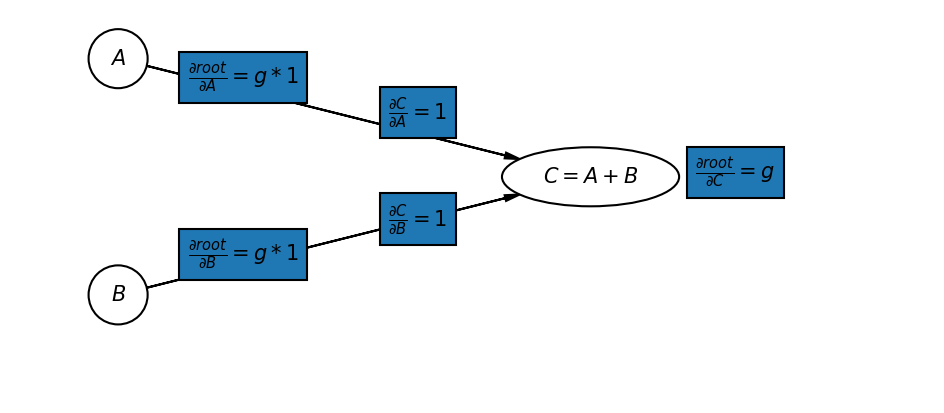

`root` is the output of the complete computational graph. 

* In the `__add__` function, node `A` is stored in `self` and node B is stored in `other`. The node C which is being created is stored in `ret`.
* The derivatives of $C=C(A,B)$ with respect to its inputs are $\frac{\partial C}{\partial A} = 1$ and $\frac{\partial C}{\partial B} = 1$
* What about the argument `g`? `g` is the total backpropagated value so far. So, it's the partial derivative of the output of the computational graph with respect to C, let's call it $\frac{\partial root}{\partial C}$ . The chain rule tells us to get the value of the entire computational graph with respect to `A` and `B`, we multiply this value with the current branch respectively. I.e.
   $$\frac{\partial root}{\partial A} = \frac{\partial root}{\partial C} * \frac{\partial C}{\partial A} = g * \frac{\partial C}{\partial A}$$
   
   $$\frac{\partial root}{\partial B} = \frac{\partial root}{\partial C} * \frac{\partial C}{\partial B} = g * \frac{\partial C}{\partial B}$$
* We pass the value $g * 1$ or just $g$ to the grad function of both `A` and `B`. We use the `combine_dicts` helper to produce the joined dictionary { 'A' : $\frac{\partial root}{\partial A}$ , 'B' : $\frac{\partial root}{\partial B}$ } if `A` and `B` are named input nodes in the computational graph.

**Task:** Implement the multiplication and square ($^2$) operators.

In [18]:
def __mul__(self, other):
    assert isinstance(other, Scalar)
    raise NotImplementedError()
    
    
    
def square(self):
    assert isinstance(other, Scalar)
    raise NotImplementedError()  

Scalar.__mul__ = __mul__
Scalar.square = square

### Example: A computational graph using autodiff
Consider this computational graph.

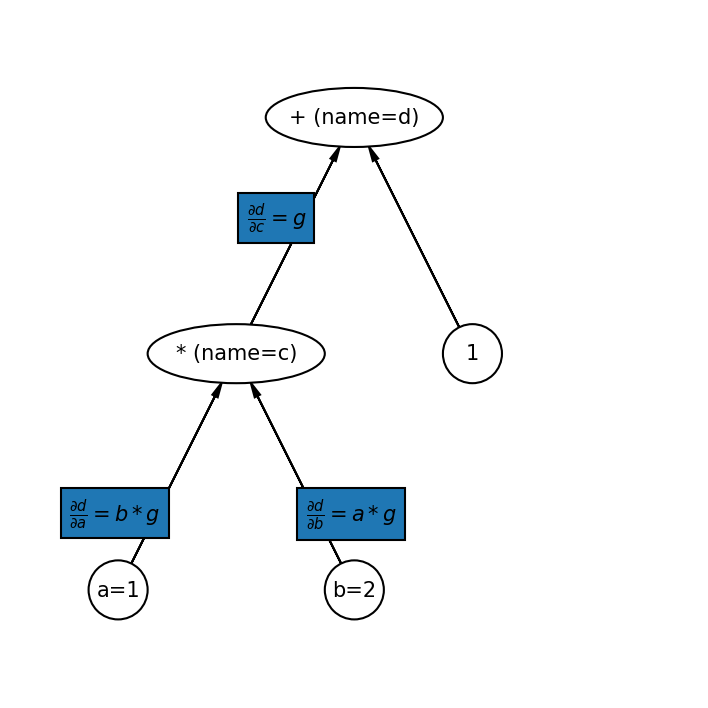
               
$g$ is the backpropagated "gradient value" - in general it is different at each position. It starts at the root of the tree with $g = 1$  ($\frac{\partial root}{\partial root} = 1$).

Example:
$$
d = (a * b) + 1
$$

$$
\frac{\partial d}{\partial a} = \frac{\partial (a*b+1)}{ \partial a} = b
$$

$$
\frac{\partial d}{\partial b} = \frac{\partial (a*b+1)}{ \partial b} = a
$$

In Python code using our autodiff `Scalar` class, we can construct the graph above
dynamically via the actual forward computation. That is called _Define-by-Run_. 
Then, we can compute the derivatives by calling `grad(1)` on the output of the graph.

In [20]:
# Chain basic operations to construct a graph
a = Scalar(1., 'a')
b = Scalar(2., 'b')
c = b * a 
d = c + Scalar(1.)

# Compute the derivatives of d with respect to a and b
derivatives = d.grad(1)
derivatives

{'b': 1.0, 'a': 2.0}

**Verify your implementation:** You can run the following tests to test if your implementation is working as expected

In [21]:
# test forward pass of multiplication
assert d.value == 3.

# test backward path of multipication
assert d.grad(1)['a']==2.0
assert d.grad(1)['b']==1.0

In [22]:
a = Scalar(1., 'a')
b = Scalar(3., 'b')
c = b.square() * a 
d = (c + Scalar(1.)).square()

# test forward pass 
assert d.value == 100.

In [23]:
# test backward pass 
assert d.grad(1)['a'] == 180
assert d.grad(1)['b'] == 120

### Exercise: Linear Regression using autodiff

In this exercise, you have to implement _Linear Regression_ as a non-trivial example to show how 
the autodiff class can be used.

In [24]:
# generate some train data
x_min = -10.
x_max = 10.
m = 10

x = np.random.uniform(x_min, x_max, m)
a = 10.
c = 5.
y_noise_sigma = 3.
y = a + c * x + np.random.randn(len(x)) * y_noise_sigma

Text(0, 0.5, 'y')

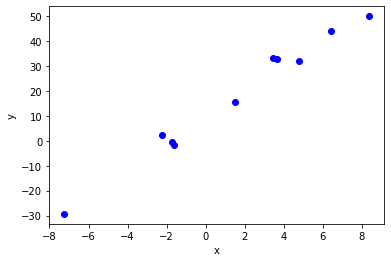

In [25]:
plt.plot(x, y, "bo")
plt.xlabel("x")
plt.ylabel("y")

#### Task:  Implement and apply _linear regression_

In the following task, you have to implement linear regression using the `Scalar` class.

1. Implement the linear model and the cost function using the `Scalar` class. For the cost function you have to loop over the complete training data set. `Scalar` don't allow any vectorized implementation. So each $x^{(i)}$
and each $y^{(i)}$ becomes a node in the computational graph. Use the given training data stored in `x` and `y`. 

The linear model is:  
> $h(x^{(i)}) = b + x^{(i)} * w$
- with an input $x^{(i)}$ with bias $b$ and weight $w$. $b$ and $w$ are the parameters of the model.

The mean-squared-error cost is the sum over $m$ samples with ground truth data values $y^{(i)}$:
> $cost =\frac{1}{m}\sum_{i=1}^{m}{(h(x^{(i)})-y^{(i)})^2}$


2. Implement gradient descent and train the model with the data. 
You can compute the derivatives of the cost function with a single call `cost.grad(1)`. The value $1$ is backpropagated through the graph and you obtain the derivatives of the cost w.r.t the weight $\frac{\partial{cost}}{\partial w}$ and w.r.t to the bias $\frac{\partial{cost}}{\partial b}$.
Use these derivatives in gradient descent to optimize the model.

3. Plot 
 - the training progress and 
 - fitted model with the data
 
 to show that your implementation works. The result should look like this:

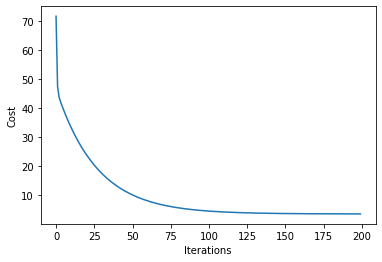

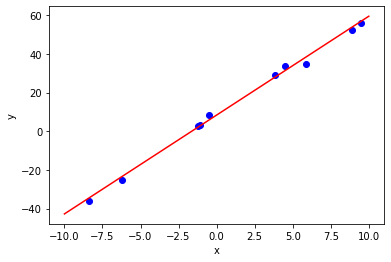

## Literature

<table>
    <tr>
        <td>
            <a name="AP17"></a>[AP17]
        </td>
        <td>
            Apache MXNet, "Deep Learning Programming Style". [Online]. Available: <a href="http://mxnet.incubator.apache.org/versions/master/architecture/program_model.html">http://mxnet.incubator.apache.org/versions/master/architecture/program_model.html</a> [Accessed: 17-Feb- 2019]
        </td>
    </tr>
    <tr>
        <td>
            <a name="OLA15"></a>[OLA15]
        </td>
        <td>
            C. Olah, "Calculus on Computational Graphs: Backpropagation" - Blog Article, August 31, 2015. [Online] Available: <a href='http://colah.github.io/posts/2015-08-Backprop/'>http://colah.github.io/posts/2015-08-Backprop/</a> [Accessed: 17- Feb- 2019]
        </td>
    </tr>
    <tr>
        <td>
            <a name="BAY18"></a>[BAY18]
        </td>
        <td>
            Atilim Gunes Baydin, Barak A. Pearlmutter, Alexey Andreyevich Radul, Jeffrey Mark Siskind, "Automatic differentiation in machine learning: a survey", Journal of Machine Learning Research 18 (2018) 1-43  Apr. 2018. [Online]. Available: <a href="http://jmlr.org/papers/volume18/17-468/17-468.pdf">http://jmlr.org/papers/volume18/17-468/17-468.pdf</a> [Accessed: 17- Feb- 2019].
        </td>
    </tr>
    <tr>
        <td>
            <a name="LM"></a>[LM]
        </td>
        <td>
            Erik Learned-Miller, 'Vector, Matrix, and Tensor Derivatives'. [Online]. Available: <a href="http://cs231n.stanford.edu/vecDerivs.pdf">http://cs231n.stanford.edu/vecDerivs.pdf</a> [Accessed: 17- Feb- 2019].
        </td>
    </tr>
    <tr>
        <td>
            <a name="KAR"></a>[KAR]
        </td>
        <td>
            A.Karpathy, Lecture Notes CS 231 Convolutional Neural Networks for Visual Recognition: Backpropagation, Year Published. [Online]. Available: <a href="http://cs231n.github.io/optimization-2/)">http://cs231n.github.io/optimization-2/)</a> [Accessed: 17- Feb- 2019].
        </td>
    </tr>
    <tr>
        <td>
            <a name="KAR"></a>[KAR]
        </td>
        <td>
            Michael Collins, Computational Graphs, and Backpropagation, Course notes for NLP, Online Available: <a href="http://www.cs.columbia.edu/~mcollins/ff2.pdf)">http://www.cs.columbia.edu/~mcollins/ff2.pdf)</a> [Accessed: 17- Feb- 2019].
        </td>
    </tr>
    
    
    
    
</table>

## Licenses


### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

_Automatic Differentiation for Scalars_ <br/>
by _[Christian Herta](https://www.htw-berlin.de/forschung/online-forschungskatalog/publikationen/person/?eid=2605)_ <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2019 _[Christian Herta](https://www.htw-berlin.de/forschung/online-forschungskatalog/publikationen/person/?eid=2605)_

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.